<font color = 'red'>
Content: 

1. [Importing Libraries](#1)
1. [Reading CSV File and Preprocessing](#2)
1. [Hyperparameters](#3)
1. [Selecting Device (GPU - CPU)](#4)
1. [Defining Dataset and Dataloader](#5)
1. [Display Frames](#6)
1. [Training FasterRCNN Model](#7)
1. [Saving Models](#8)
1. [Loading Model](#9)
1. [Testing on Video with OpenCV](#10)


In [2]:
! pip install albumentations==0.4.6

<a id = "1"></a><br>
# Importing Libraries

In [3]:
from time import time
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import random

from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms
import torchvision.transforms as transforms


from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

torch.cuda.empty_cache() 

import os

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
!pwd
!ls

/content
fasterrcnn_resnet0_fpn.pth  input			    sample_data
fasterrcnn_resnet1_fpn.pth  lisa-traffic-light-dataset.zip
fasterrcnn_vgg0_fpn.pth     mydata


In [5]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 71 Dec 17 22:38 kaggle.json


In [6]:
!kaggle datasets download --force -d mbornoe/lisa-traffic-light-dataset

100% 4.21G/4.21G [01:13<00:00, 50.6MB/s]
100% 4.21G/4.21G [01:13<00:00, 61.3MB/s]


In [7]:
!pwd
!ls
!rm -r input/
!unzip -q lisa-traffic-light-dataset.zip -d input/

/content
lisa-traffic-light-dataset.zip	sample_data
rm: cannot remove 'input/': No such file or directory


In [8]:
# from google.colab import files
# uploaded = files.upload()

<a id = "2"></a><br>
# Reading CSV File and Preprocessing

In [7]:
DATA_PATH = '/content/input'
os.listdir(DATA_PATH)

['sample-nightClip1',
 'dayTrain',
 'daySequence2',
 'Annotations',
 'nightSequence1',
 'nightTrain',
 'sample-dayClip6',
 'daySequence1',
 'nightSequence2']

In [8]:
DAY_TRAIN_PATH = '/content/input/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = '/content/input/Annotations/Annotations/nightTrain/'

In [9]:
train_day = []

# Walk through dirs in DAY_TRAIN_PATH, get their dfs and concatenate them
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)
train_day_df.head()

100%|██████████| 13/13 [00:00<00:00, 93.81it/s]


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2


In [10]:
# Drop some columns
train_day_df = train_day_df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)
train_day_df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,1
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,1
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,2


In [12]:
# edit the filenames so the fit on one line
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
   
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

train_day_df['Filename'] = train_day_df.apply(changeFilename,axis=1)
train_day_df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number
0,/content/input/dayTrain/dayTrain/dayClip1/fram...,go,698,333,710,358,0
1,/content/input/dayTrain/dayTrain/dayClip1/fram...,go,846,391,858,411,0
2,/content/input/dayTrain/dayTrain/dayClip1/fram...,go,698,337,710,357,1
3,/content/input/dayTrain/dayTrain/dayClip1/fram...,go,847,390,859,410,1
4,/content/input/dayTrain/dayTrain/dayClip1/fram...,go,698,331,710,356,2


In [13]:
train_day_df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [14]:
# Change annotation tags to integers instead of strings with the dict below
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
train_day_df['Annotation tag'] = train_day_df.apply(changeAnnotation,axis=1)

annotation_tags = train_day_df['Annotation tag'].unique()
print(annotation_tags)
train_day_df.head()

[1 3 2]


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number
0,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,333,710,358,0
1,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,846,391,858,411,0
2,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,337,710,357,1
3,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,847,390,859,410,1
4,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,331,710,356,2


In [15]:
# Rename the columns to be smaller
train_day_df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame']
train_day_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame
0,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,333,710,358,0
1,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,846,391,858,411,0
2,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,337,710,357,1
3,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,847,390,859,410,1
4,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,331,710,356,2


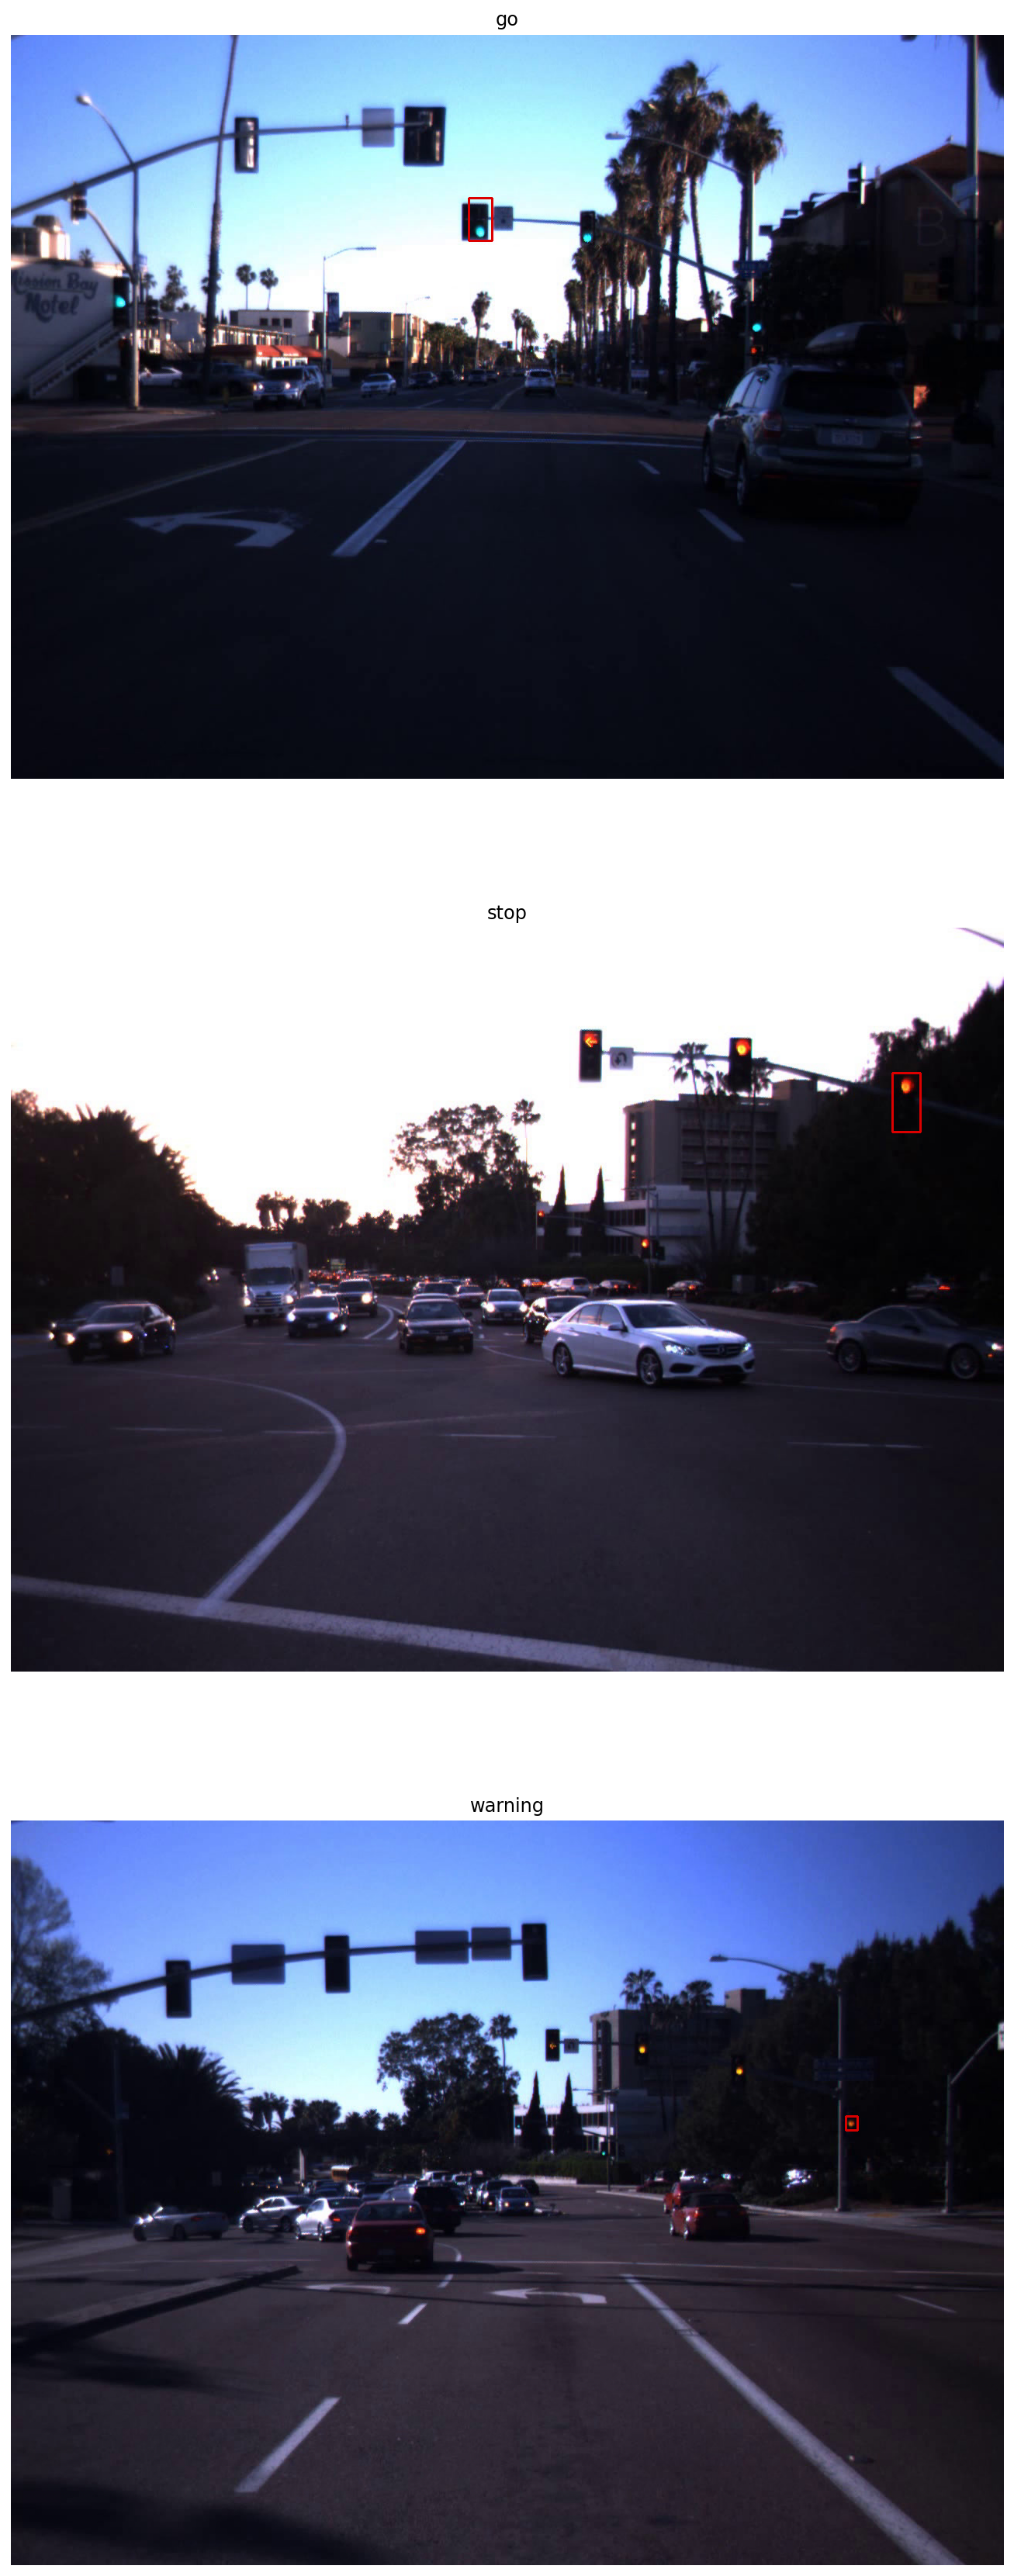

In [16]:
# sample some images from the set
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    # draw bounding boxes where there are stoplights
    sample = train_day_df[train_day_df['label']==tag].sample(1)
    bbox = sample[['x_min', 'y_min', 'x_max', 'y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [17]:
train_day_df['clipNames'] = train_day_df[['image_id']].applymap(lambda x: x.split('/')[5])
train_day_df['clipNames'].unique()
train_day_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,clipNames
0,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,333,710,358,0,dayClip1
1,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,846,391,858,411,0,dayClip1
2,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,337,710,357,1,dayClip1
3,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,847,390,859,410,1,dayClip1
4,/content/input/dayTrain/dayTrain/dayClip1/fram...,1,698,331,710,356,2,dayClip1


In [28]:
!rm -r mydata
!mkdir mydata
!mkdir mydata/yes
!mkdir mydata/no

In [29]:
# GENERATE NEW DATASET
from PIL import Image
import random

# iterate through each bounding box
    # for each bounding box:
        # do a semi random square crop around the bounding box location
        # save that image to the new dataset with classification label "yes/1"
        
        # do a crop directly below the previous image (without a stop light)
        # save that image to a new dataset with classification label "no/0"

def crop_traffic_light(img, bbox, zoom = 80, center_adjust=60):
    # bbox is tuple ('x_min','y_min','x_max','y_max')

    # Randomly crop around the bounding box
    x_min, y_min, x_max, y_max = bbox
    center_x = (x_min + x_max)/2 + random.randint(-center_adjust, center_adjust)
    center_y = (y_min + y_max)/2 + random.randint(-center_adjust, center_adjust)
    
    width, height = img.size

    # Make sure the newly cropped box doesn't go out of range
    if center_x + zoom > width:
        center_x = width - zoom
    elif center_x - zoom < 0:
        center_x = zoom
    if center_y + zoom > height:
        center_y = height - zoom
    elif center_y - zoom < 0:
        center_y = zoom
    
    left = center_x - zoom
    right = center_x + zoom
    top = center_y - zoom
    bottom = center_y + zoom

    res = img.crop((left, top, right, bottom))
    return res

def crop_no_light(img, bbox, zoom=128):
    # bbox is tuple ('x_min', 'y_min', 'x_max', 'y_max')

    # Crop directly below the bounding box
    x_min, y_min, x_max, y_max = bbox
    center_x = (x_min + x_max)/2
    center_y = (y_min + y_max)/2 + random.randint(350, 500)
    
    width, height = img.size

    # Make sure the newly cropped box doesn't go out of range
    if center_x + zoom > width:
        center_x = width - zoom
    elif center_x - zoom < 0:
        center_x = zoom
    if center_y + zoom > height:
        center_y = height - zoom
    elif center_y - zoom < 0:
        center_y = zoom

    left = center_x - 128
    right = center_x + 128
    top = center_y - 128
    bottom = center_y + 128

    res = img.crop((left, top, right, bottom))
    return res

def get_darkness(img):
    np_img = np.array(img)
    mean = np_img.mean()
    return mean

def add_to_dataset(index, positive_img, negative_img, threshold=40):
    if get_darkness(positive_img) > threshold:
        pos_img = positive_img.save('/content/mydata/yes/' + str(index) + '.jpg', 'JPEG')
    else:
        bad_imgs.append(positive_img)
    if get_darkness(negative_img) > threshold:
        neg_img = negative_img.save('/content/mydata/no/' + str(index) + '.jpg', 'JPEG')
    else:
        bad_imgs.append(negative_img)

count = 0
size = 2400e3

bad_imgs = []

for index, row in train_day_df.iterrows():
    filename = row['image_id']
    bbox = (row['x_min'], row['y_min'], row['x_max'], row['y_max'])
    img = Image.open(filename)
    positive_img = crop_traffic_light(img, bbox) # yes
    negative_img = crop_no_light(img, bbox) # no
    
    # add to new dataset
    add_to_dataset(index, positive_img, negative_img)
    count += 1
    if count >= size:
        break

print(count)

37810


24562


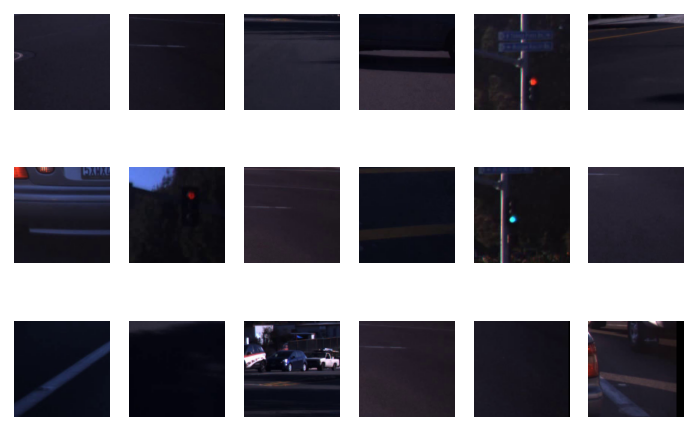

In [31]:
print(len(bad_imgs))
sample_size = 18
img_samples = random.sample(bad_imgs, sample_size)

fig, axs = plt.subplots(3, 6)

count = 0

for n in range(3):
    for v in range(6):
        img = img_samples[count]
        currAxis = axs[n, v]
        currAxis.imshow(img)
        currAxis.autoscale(False)
        count += 1

#Turn off all irrelevant axes
for row in range(3):
    for col in range(6):
        currAxis = axs[row, col]
        currAxis.axis("off")

In [32]:
from torchvision import datasets, transforms, models


data_dir = '/content/mydata/'

train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])

def load_split_train_test(datadir, valid_size = .2):
    
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['no', 'yes']


In [33]:
# ResNet50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
# print(model)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512, 10),
                        nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print("hello")

hello


In [22]:
# VGG16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
# print(model)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 2),                   
                      nn.LogSoftmax(dim=1))
                      
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.003)
model.to(device)
#print("hello")

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()



Epoch 1/1.. Train loss: 3.147.. Test loss: 1.744.. Test accuracy: 0.455
Epoch 1/1.. Train loss: 0.783.. Test loss: 1.188.. Test accuracy: 0.596
Epoch 1/1.. Train loss: 0.184.. Test loss: 0.046.. Test accuracy: 0.987
Epoch 1/1.. Train loss: 0.040.. Test loss: 0.023.. Test accuracy: 0.993
Epoch 1/1.. Train loss: 0.032.. Test loss: 0.015.. Test accuracy: 0.995
Epoch 1/1.. Train loss: 0.027.. Test loss: 0.010.. Test accuracy: 0.997
Epoch 1/1.. Train loss: 0.012.. Test loss: 0.010.. Test accuracy: 0.997
Epoch 1/1.. Train loss: 0.008.. Test loss: 0.008.. Test accuracy: 0.998
Epoch 1/1.. Train loss: 0.007.. Test loss: 0.008.. Test accuracy: 0.997
Epoch 1/1.. Train loss: 0.008.. Test loss: 0.008.. Test accuracy: 0.997
Epoch 1/1.. Train loss: 0.007.. Test loss: 0.007.. Test accuracy: 0.998
Epoch 1/1.. Train loss: 0.005.. Test loss: 0.007.. Test accuracy: 0.998
Epoch 1/1.. Train loss: 0.012.. Test loss: 0.010.. Test accuracy: 0.997
Epoch 1/1.. Train loss: 0.021.. Test loss: 0.005.. Test accuracy

In [35]:
torch.save(model, 'fasterrcnn_resnet2_fpn.pth')

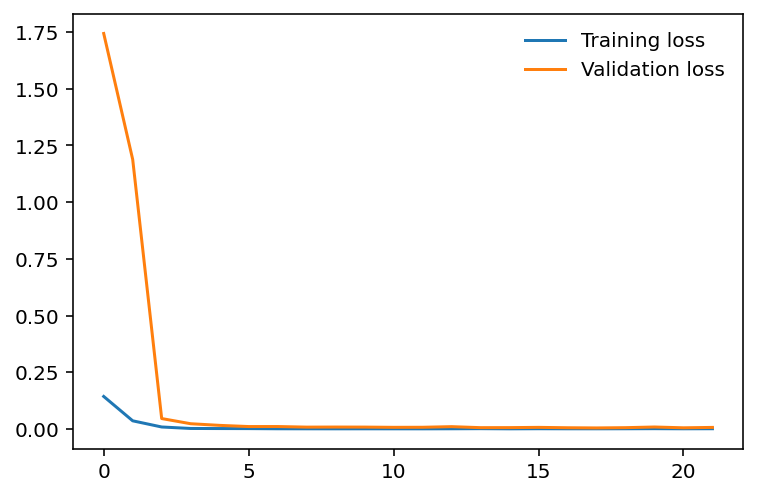

In [36]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [37]:
# run if training this model for the first time

PATH = "/content/fasterrcnn_resnet2_fpn.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m = torch.load(PATH)
m.eval()
print("hello")

hello


In [27]:
# Run the cell when loading a model without training it.

PATH = "/content/fasterrcnn_resnet0_fpn.pth"

"""m = models.resnet50(pretrained=True)
m.fc = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(512, 10),
                        nn.LogSoftmax(dim=1))
"""
m = torch.load(PATH)
m.eval()
print("hello")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
m.cuda()

def predict_image(image):
    # print("hello")
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0).to(device)
    #input = Variable(image_tensor)
    #input = input.to(device)
    output = m(image_tensor)
    index = output.data.cpu().numpy().argmax()
    return index

In [43]:
"""print(len(testloader))
batch_count = 0
for images, labels in testloader:
    batch_count += 1
    if batch_count % 5 == 0:
        print(batch_count)

print(batch_count)
"""

'print(len(testloader))\nbatch_count = 0\nfor images, labels in testloader:\n    batch_count += 1\n    if batch_count % 5 == 0:\n        print(batch_count)\n\nprint(batch_count)\n'

In [39]:
# Test on images in the test set

tran1 = transforms.ToPILImage()
count = 0

correct_imgs = []
wrong_imgs = []

for images, labels in testloader:
    for i in range(len(images)):
        image = images[i]
        label = labels[i]
        img = tran1(image)
        prediction = predict_image(img)
        
        if prediction != label.item():
            wrong_imgs.append((image, prediction))
        else:
            correct_imgs.append((image, prediction))
        count += 1

print(count)

3510


3499


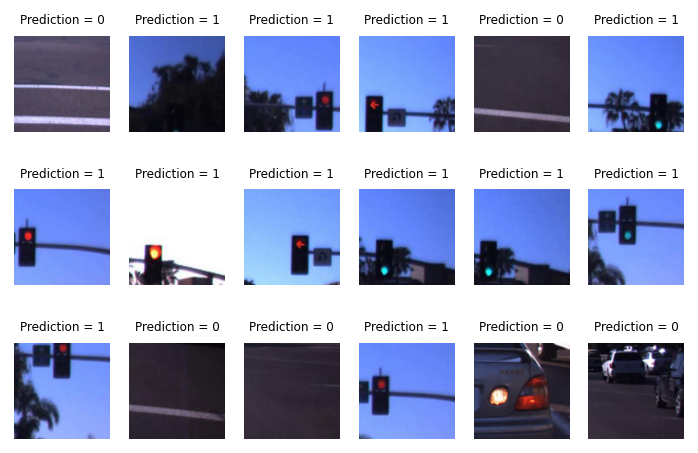

In [50]:
# Plot correct ones
print(len(correct_imgs))
sample_size = 18
img_samples = random.sample(correct_imgs, sample_size)

fig, axs = plt.subplots(3, 6)

count = 0

for n in range(3):
    for v in range(6):
        img_pred = img_samples[count]
        currAxis = axs[n, v]
        currAxis.set_title("Prediction = " + str(img_pred[1]), fontsize = 6)
        currAxis.imshow(img_pred[0].permute(1, 2, 0))
        currAxis.autoscale(False)
        count += 1

#Turn off all irrelevant axes
for row in range(3):
    for col in range(6):
        currAxis = axs[row, col]
        currAxis.axis("off")

11


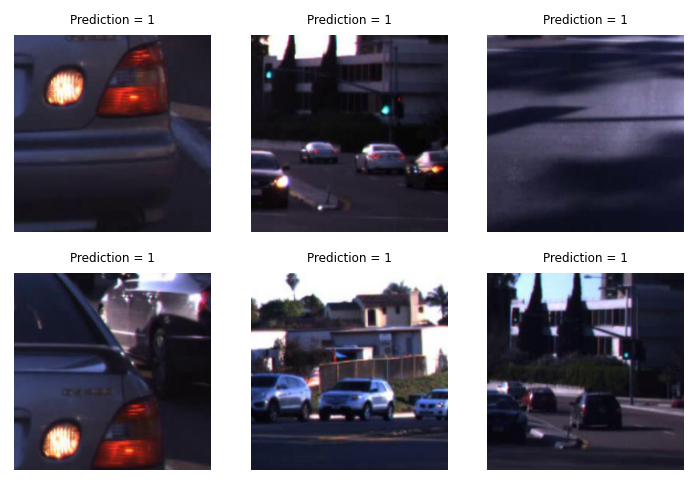

In [43]:
# Plot wrong ones
print(len(wrong_imgs))
sample_size = 6
img_samples = random.sample(wrong_imgs, sample_size)

rows = 2
cols = 3

fig, axs = plt.subplots(rows, cols)

count = 0

for n in range(rows):
    for v in range(cols):
        img_pred = img_samples[count]
        currAxis = axs[n, v]
        currAxis.set_title("Prediction = " + str(img_pred[1]), fontsize = 6)
        currAxis.imshow(img_pred[0].permute(1, 2, 0))
        currAxis.autoscale(False)
        count += 1

#Turn off all irrelevant axes
for row in range(rows):
    for col in range(cols):
        currAxis = axs[row, col]
        currAxis.axis("off")

In [48]:
accuracy_list = [1] * len(correct_imgs) + [0] * len(wrong_imgs)

batch_size = 9
num_trials = 100000

batch_accuracy = np.average([np.average(random.sample(accuracy_list, batch_size)) == 1 for _ in range(num_trials)])
batch_accuracy

0.97223

In [ ]:
# Test out the model on dataset it's never seen on completely different



In [ ]:
# NOT MY CODE
def split(df, p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    dayClips = [name for name in clipNames if 'day' in name]

    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames =  testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainClipNames =  trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df


<a id = "3"></a><br>
# Hyperparameters

In [ ]:
EPOCHS = 1
BATCH_SIZE = 2

<a id = "4"></a><br>
# Selecting Device (GPU - CPU)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

<a id = "5"></a><br>
# Defining Dataset and Dataloader

In [ ]:
# ??? NOT MY CODE
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def getTrainTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getValTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getTestTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

<a id = "6"></a><br>
# Display Frames 

In [ ]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 1)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

<a id = "7"></a><br>
# Training FasterRCNN Model

<a id = "8"></a><br>
# Saving Models

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet{}_fpn.pth'.format(epoch))

<a id = "9"></a><br>
# Loading Models

In [ ]:
model.load_state_dict(torch.load('fasterrcnn_resnet0_fpn.pth'))

<a id = "10"></a><br>
# Testing on Video with OpenCV

In [ ]:
# cross val stuff

import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import KFold

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

class SimpleConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(1, 10, kernel_size=3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(26 * 26 * 10, 50),
      nn.ReLU(),
      nn.Linear(50, 20),
      nn.ReLU(),
      nn.Linear(20, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  
if __name__ == '__main__':
  
  # Configuration options
  k_folds = 5
  num_epochs = 1
  loss_function = nn.CrossEntropyLoss()
  
  # For fold results
  results = {}
  
  # Set fixed random number seed
  torch.manual_seed(42)
  
  # Prepare MNIST dataset by concatenating Train/Test part; we split later.
  dataset_train_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=True)
  dataset_test_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=False)
  dataset = ConcatDataset([dataset_train_part, dataset_test_part])
  
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=k_folds, shuffle=True)
    
  # Start print
  print('--------------------------------')

  # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=10, sampler=test_subsampler)
    
    # Init the neural network
    network = SimpleConvNet()
    network.apply(reset_weights)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        
        # Get inputs
        inputs, targets = data
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = network(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
            
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  sum = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
  print(f'Average: {sum/len(results.items())} %')